In [1]:
!pip install tensorflow==2.15.0

In [2]:
!pip install keras

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

2024-06-04 18:18:36.363514: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 18:18:36.382623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 18:18:36.382637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 18:18:36.383539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 18:18:36.387582: I tensorflow/core/platform/cpu_feature_guar

In [4]:
print(tf.__version__)

2.15.0


In [ ]:
# Extract dataset .zip (Run it only the first time)
!unzip -o -q Dataset.zip  -d Dataset

In [ ]:
# If the dataset is corrupted, run this cell.
# It can happen that the compression process has corrupted a few images
from os import listdir, remove
from PIL import Image

path = "Dataset_compressed/VerticalLowRain/"
for filename in listdir(path):
    if filename.endswith('.jpg'):
        try:
            img = Image.open(path+filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError) as e:
            print('Bad file:', filename)
            #print('Removing file ...')
            #remove(path+filename)

In [5]:
PATH = "Dataset_compressed"
print("path: ", PATH)
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale = 1./ 255,
                                   validation_split=0.20)

train_ds = train_datagen.flow_from_directory(PATH,
                                             target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical",
                                             color_mode="rgb",
                                             shuffle=True,
                                             subset='training',
                                             seed=42,
                                             classes=['Clear', 'SlantingHeavyRain', 'VerticalHeavyRain',
                                                      'SlantingMediumRain', 'VerticalMediumRain', 'SlantingLowRain',
                                                      'VerticalLowRain'])

val_ds = train_datagen.flow_from_directory(PATH,
                                           target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical",
                                           color_mode="rgb",
                                           shuffle=True,
                                           seed=42,
                                           subset="validation",
                                           classes=['Clear', 'SlantingHeavyRain', 'VerticalHeavyRain',
                                                    'SlantingMediumRain', 'VerticalMediumRain', 'SlantingLowRain',
                                                    'VerticalLowRain'])

print(train_ds.class_indices)
print(val_ds.class_indices)

path:  Dataset_compressed
Found 267731 images belonging to 7 classes.
Found 66930 images belonging to 7 classes.
{'Clear': 0, 'SlantingHeavyRain': 1, 'VerticalHeavyRain': 2, 'SlantingMediumRain': 3, 'VerticalMediumRain': 4, 'SlantingLowRain': 5, 'VerticalLowRain': 6}
{'Clear': 0, 'SlantingHeavyRain': 1, 'VerticalHeavyRain': 2, 'SlantingMediumRain': 3, 'VerticalMediumRain': 4, 'SlantingLowRain': 5, 'VerticalLowRain': 6}


Text(0.5, 1.0, '[0. 0. 0. 0. 1. 0. 0.]')

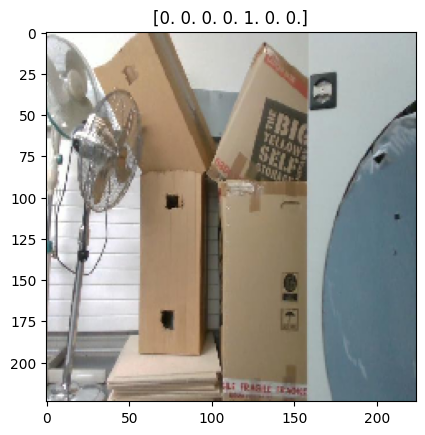

In [6]:
import matplotlib.pyplot as plt

# Load the first bath of data
images, labels = next(val_ds)

# Display an image
plt.imshow(images[0])
plt.title(labels[0])

In [7]:
test_ds = []
for i in range (0, 128):
    img = np.expand_dims(images[i], 0)
    test_ds.append(img)

In [8]:
# Load the tflite model
TFLITE_FILE_PATH = "TFliteMobileNetSmallV3.2/model.tflite"
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
# Measure the elapsed time of the classification of a batch of images (i.e., 128)
import time
elapsed_time = []
for i in range (0, 128):  
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], test_ds[i])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()
    elapsed_time.append(end - start)
    
print(elapsed_time)

[0.0021414756774902344, 0.000993490219116211, 0.000949859619140625, 0.0009555816650390625, 0.0009486675262451172, 0.0009500980377197266, 0.0009493827819824219, 0.0009531974792480469, 0.0009508132934570312, 0.0009491443634033203, 0.0009486675262451172, 0.0009534358978271484, 0.0009539127349853516, 0.0009484291076660156, 0.0009491443634033203, 0.0009465217590332031, 0.0009534358978271484, 0.0009481906890869141, 0.0009572505950927734, 0.000949859619140625, 0.0009515285491943359, 0.0009493827819824219, 0.0009484291076660156, 0.0009844303131103516, 0.0010242462158203125, 0.001010894775390625, 0.0010285377502441406, 0.001007080078125, 0.0009891986846923828, 0.001013040542602539, 0.0010120868682861328, 0.0009851455688476562, 0.001004934310913086, 0.0010154247283935547, 0.0010099411010742188, 0.000988006591796875, 0.0009944438934326172, 0.000985860824584961, 0.000985860824584961, 0.0009839534759521484, 0.0009889602661132812, 0.0009872913360595703, 0.0009870529174804688, 0.0009868144989013672, 

In [10]:
# Compute the mean time needed to classify 1 image
import statistics
mean_elapsed_time = statistics.mean(elapsed_time)
print(mean_elapsed_time)

0.0006955023854970932
